<center>
    <h1>Fruit Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

# Fruit Inspection

In [19]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

In [20]:
print(f'Using OpenCV version: {cv2.__version__}')

Using OpenCV version: 4.6.0


In [21]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# First task: Fruit Segmentation and Defect Detection

In [22]:
dir_1 = 'images/first task/'
grayscale_names_1, color_names_1 = [[f'{dir_1}C{j}_00000{i}.png' for i in range(1,4)] for j in [0,1]]

In [23]:
print(grayscale_names_1)
print(color_names_1)

['images/first task/C0_000001.png', 'images/first task/C0_000002.png', 'images/first task/C0_000003.png']
['images/first task/C1_000001.png', 'images/first task/C1_000002.png', 'images/first task/C1_000003.png']


In [24]:
grayscale_imgs_1 = [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in grayscale_names_1]
color_imgs_1 = [cv2.imread(i) for i in color_names_1]

In [25]:
def plot_image_grid(images, title, show_axis=True):
    fig = plt.figure(figsize=(20,5))
    fig.suptitle(title, fontsize=20)
    for idx, img in enumerate(images):
        plt.subplot(1, len(images), idx+1)
        plt.axis('on' if show_axis else 'off')
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

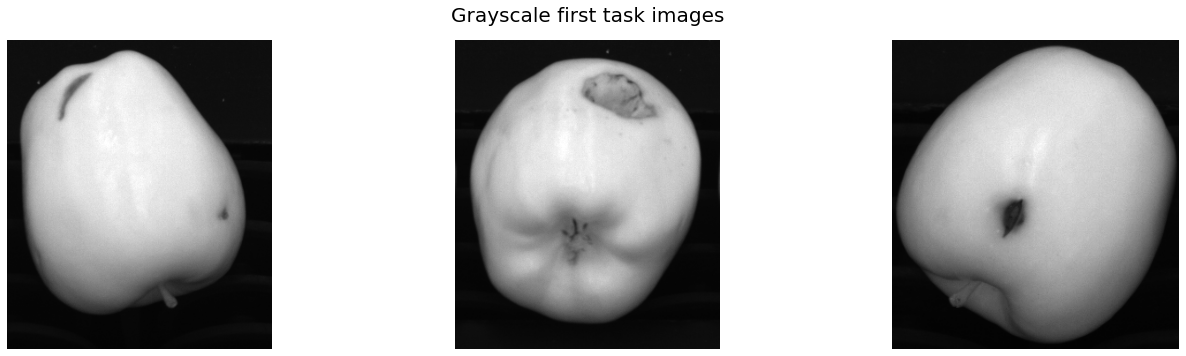

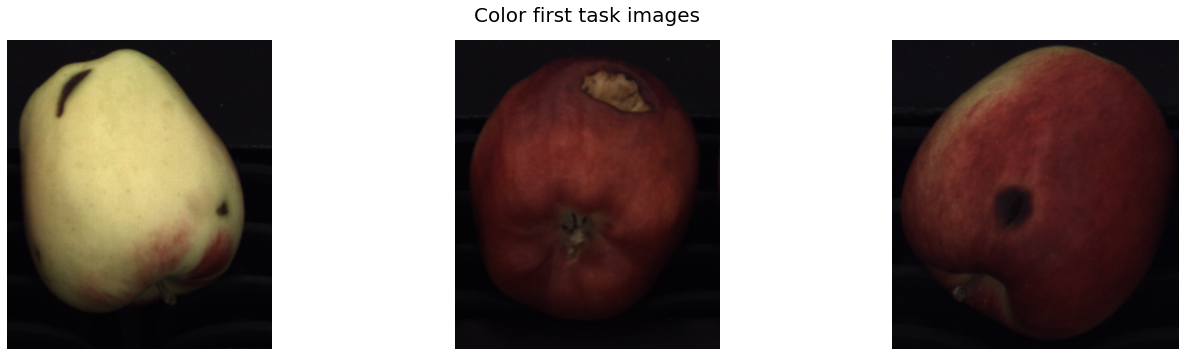

In [26]:
plot_image_grid(grayscale_imgs_1, 'Grayscale first task images', show_axis=False)
plot_image_grid(color_imgs_1, 'Color first task images', show_axis=False)

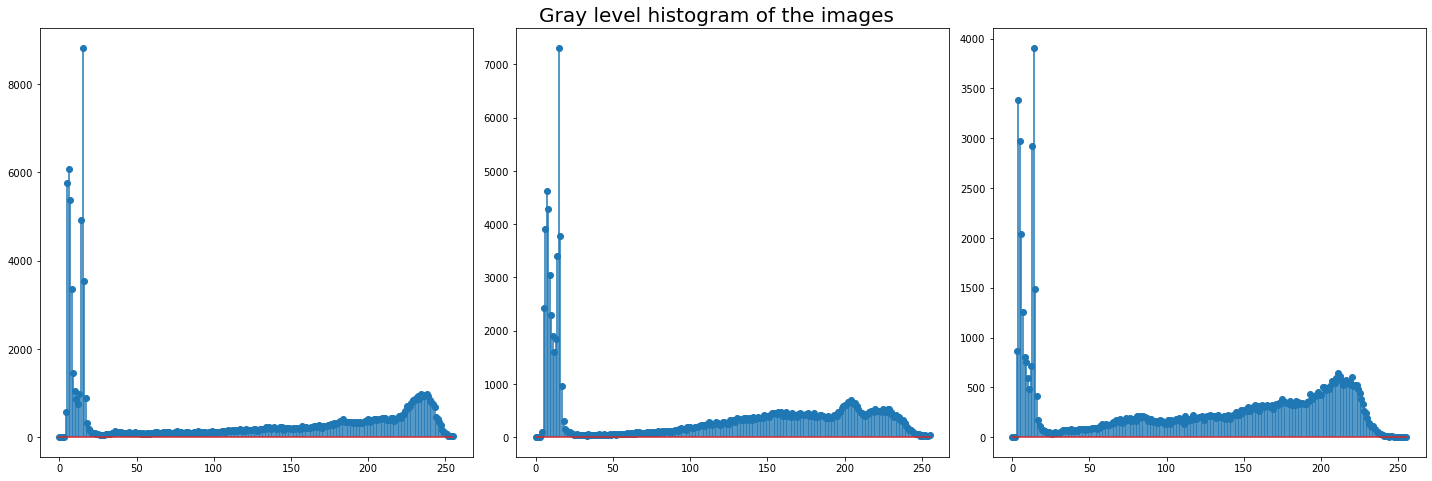

In [27]:
fig = plt.figure(figsize=(20,13))
fig.suptitle('Gray level histogram of the images', fontsize=20)
for idx, img in enumerate(grayscale_imgs_1):
    plt.subplot(2, 3, idx+1)
    hist, _ = np.histogram(img.flatten(), 256, [0,256])
    plt.stem(hist, use_line_collection=True)
plt.tight_layout()
plt.show()

## Outline the fruit by generating a binary mask

In order to solve the binarization task binary segmentation has to be applied. A threshold has to be found. 3 methods:

- Binarization by intensity thresholding
- Otsu's Algorithm
- Adaptive Thresholding

In [28]:
# img = grayscale_imgs_1[0]
# img_clr = color_imgs_1[0]

In [29]:
def apply_flood_fill(image):
    # Copy the thresholded image.
    im_floodfill = image.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    return image | im_floodfill_inv

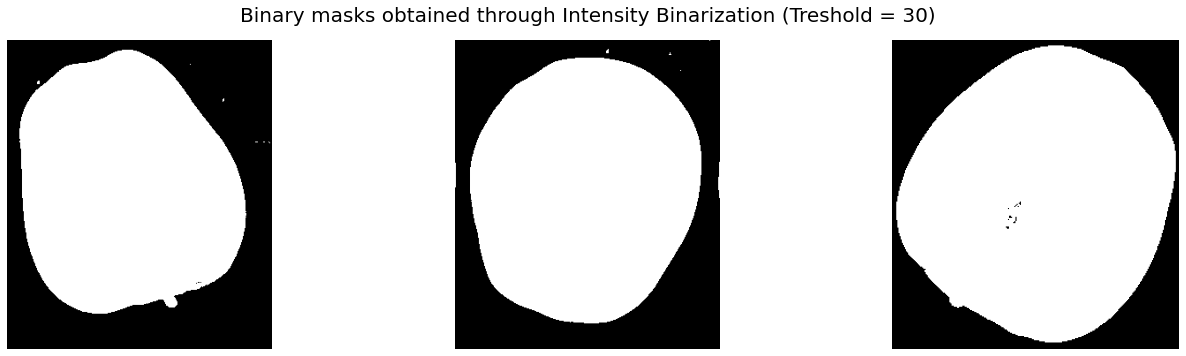

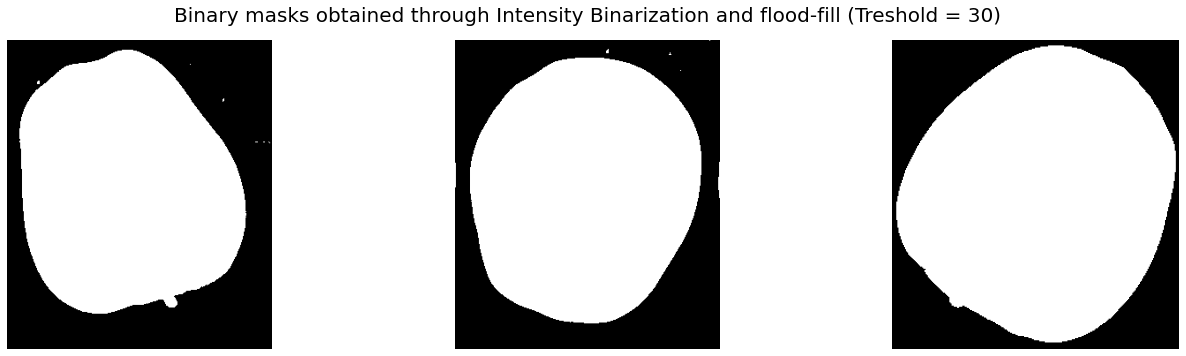

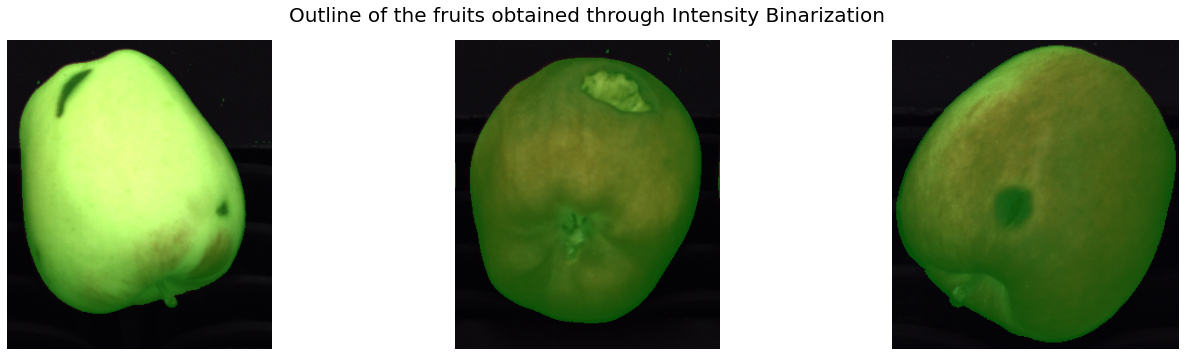

In [111]:
# TODO Parametrize
# this is just for visualization.
# By looking at the greyscale histogram it is evident that the image is not inherently binary 
# and a clear threshold dividing background and foreground + imperfercions can't be found manually.
MANUAL_TRESHOLD = 50

masks = [cv2.threshold(i, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)[1] for i in grayscale_imgs_1]

plot_image_grid(masks, 
                f'Binary masks obtained through Intensity Binarization (Treshold = {MANUAL_TRESHOLD})', 
                show_axis=False)

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 
                f'Binary masks obtained through Intensity Binarization and flood-fill (Treshold = {MANUAL_TRESHOLD})', 
                show_axis=False)

bounded_images = []

for idx, img in enumerate(color_imgs_1):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 
                'Outline of the fruits obtained through Intensity Binarization', 
                show_axis=False)

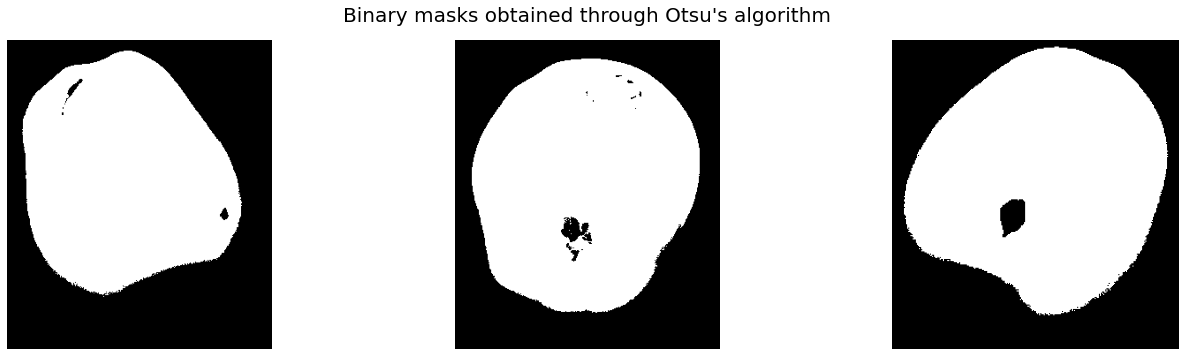

Tresholds obtained for each image: [109.0, 98.0, 104.0]


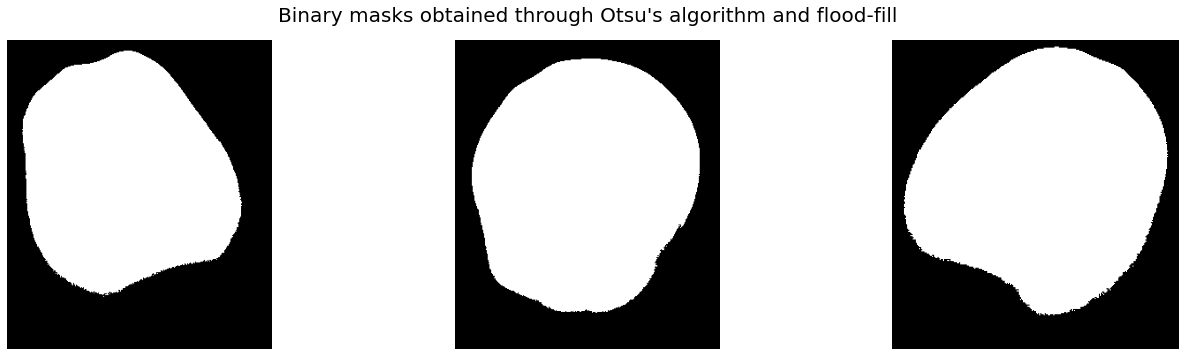

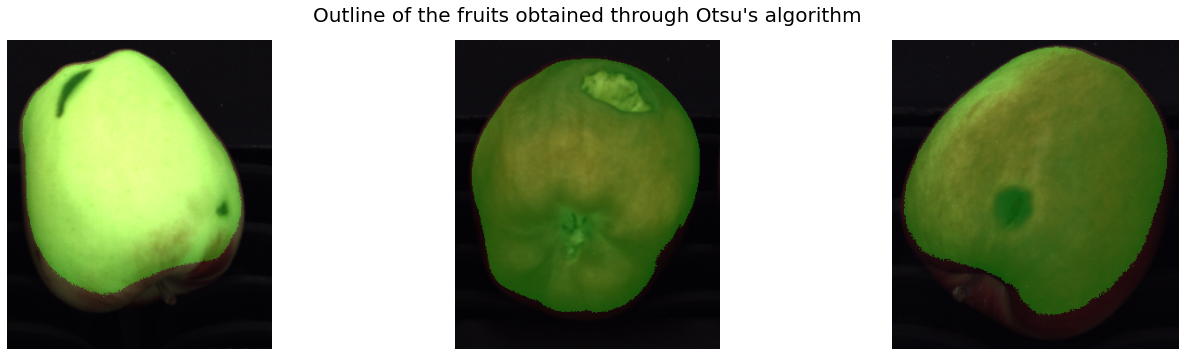

In [31]:
masks = []
tresholds = []

for img in grayscale_imgs_1:
    treshold, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)

plot_image_grid(masks, 
                f'Binary masks obtained through Otsu\'s algorithm', 
                show_axis=False)

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 
                'Binary masks obtained through Otsu\'s algorithm and flood-fill', 
                show_axis=False)

bounded_images = []

for idx, img in enumerate(color_imgs_1):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 
                'Outline of the fruits obtained through Otsu\'s algorithm', 
                show_axis=False)

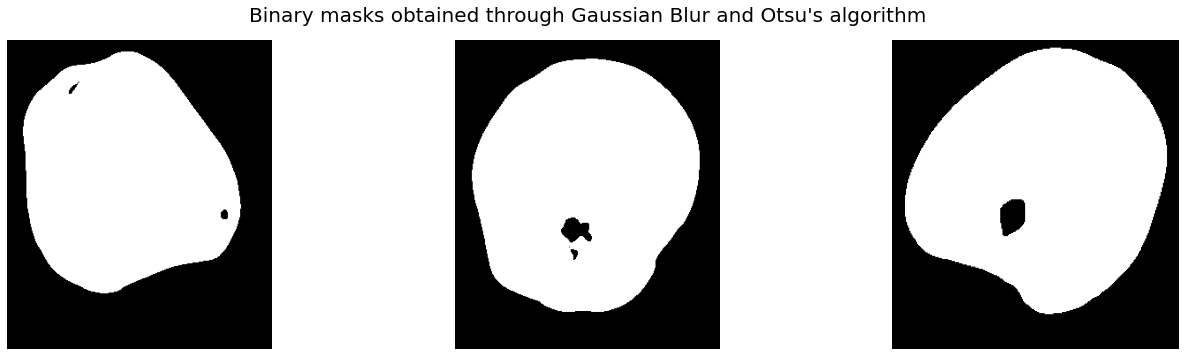

Tresholds obtained for each image: [110.0, 98.0, 105.0]


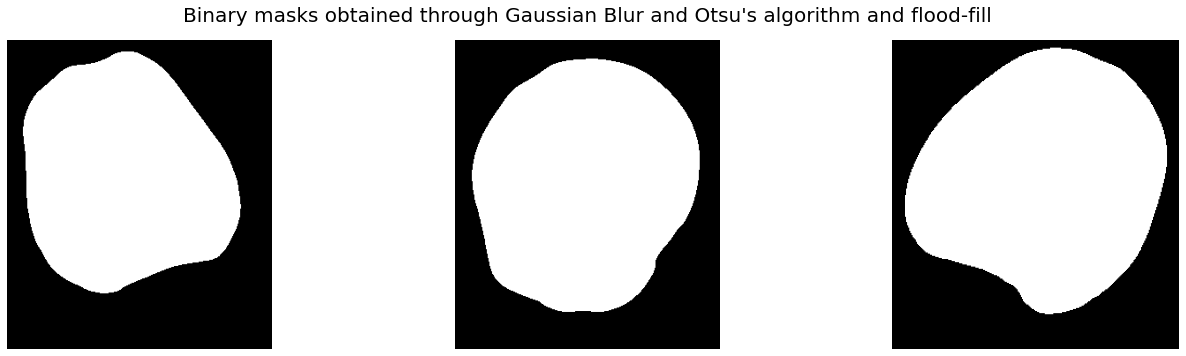

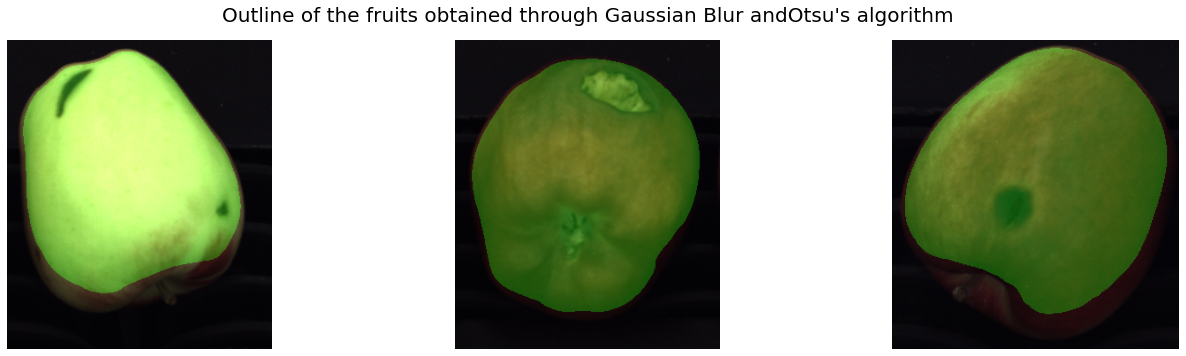

In [110]:
masks = []
tresholds = []

for img in grayscale_imgs_1:
    sigma=2
    k = math.ceil(3*sigma)
    blur = cv2.GaussianBlur(img, (2*k+1, 2*k+1), sigma)
    treshold, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)

plot_image_grid(masks, 
                f'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm', 
                show_axis=False)

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 
                'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm and flood-fill', 
                show_axis=False)

bounded_images = []

for idx, img in enumerate(color_imgs_1):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 
                'Outline of the fruits obtained through Gaussian Blur andOtsu\'s algorithm', 
                show_axis=False)

In [33]:
'''# this is just for visualization.
# By looking at the greyscale histogram it is evident that the image is not inherently binary 
# and a clear threshold dividing background and foreground + imperfercions can't be found manually.
ret, mask = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(15,13))
# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

#print(f'The obtained threshold with Intensity Binarization is {ret}')'''

"# this is just for visualization.\n# By looking at the greyscale histogram it is evident that the image is not inherently binary \n# and a clear threshold dividing background and foreground + imperfercions can't be found manually.\nret, mask = cv2.threshold(img,100,255,cv2.THRESH_BINARY)\nfig = plt.figure(figsize=(15,13))\n# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))\nplt.imshow(mask, cmap='gray', vmin=0, vmax=255)\nplt.axis('off')\nplt.show()\n\n#print(f'The obtained threshold with Intensity Binarization is {ret}')"

In [34]:
"""ret, mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f'The obtained threshold with Otsu\'s Algorithm is {ret}')

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret,threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255, alpha=0.2)
plt.show()

print(f'The obtained threshold with Otsu\'s Algorithm + Gaussian Smoothing is {ret}')"""

"ret, mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)\n# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))\nplt.imshow(threshold, cmap='gray', vmin=0, vmax=255)\nplt.show()\n\nprint(f'The obtained threshold with Otsu's Algorithm is {ret}')\n\n# Otsu's thresholding after Gaussian filtering\nblur = cv2.GaussianBlur(img,(5,5),0)\nret,threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)\nplt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))\nplt.imshow(threshold, cmap='gray', vmin=0, vmax=255, alpha=0.2)\nplt.show()\n\nprint(f'The obtained threshold with Otsu's Algorithm + Gaussian Smoothing is {ret}')"

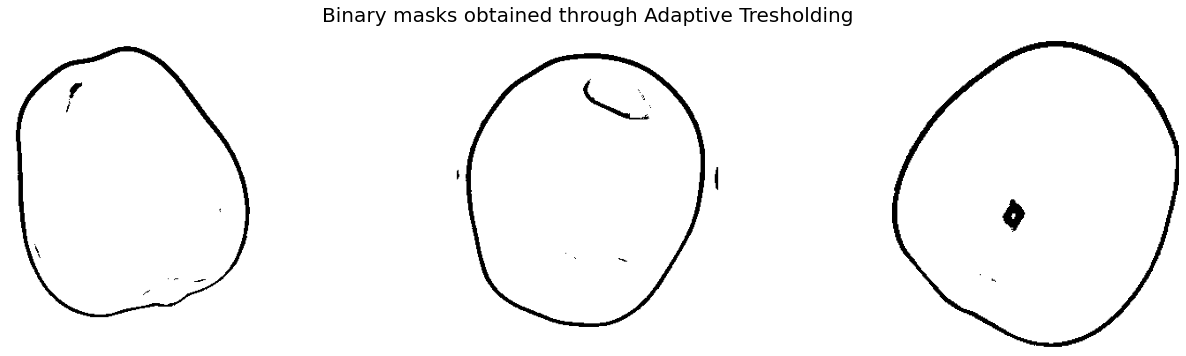

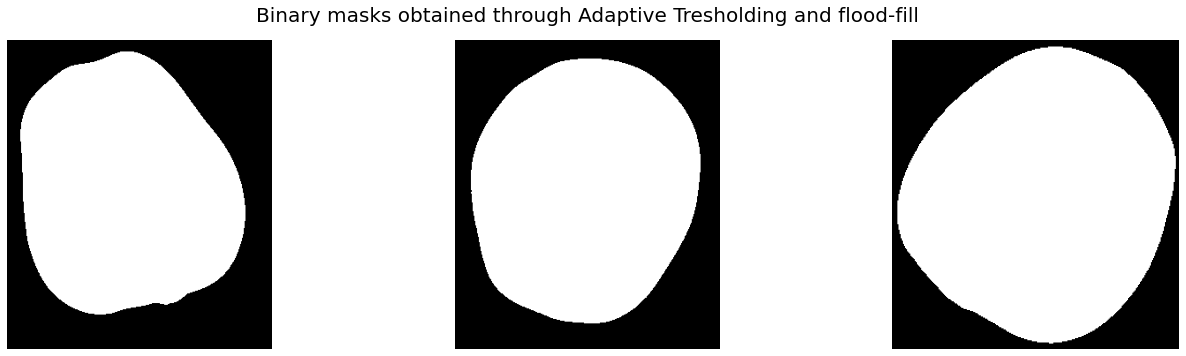

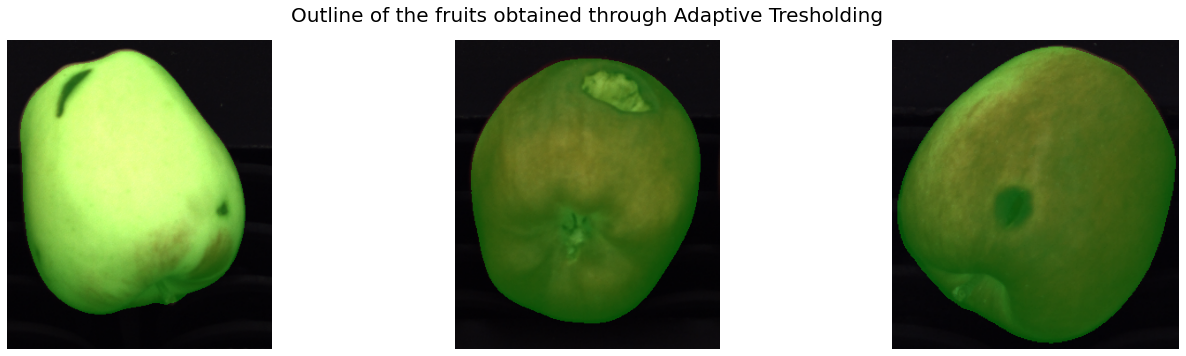

In [107]:
masks = []

for img in grayscale_imgs_1:
    img_blur = cv2.medianBlur(img, 25)
    mask = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

plot_image_grid(masks, 
                'Binary masks obtained through Adaptive Tresholding', 
                show_axis=False)

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]


masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 
                'Binary masks obtained through Adaptive Tresholding and flood-fill', 
                show_axis=False)

bounded_images = []

for idx, img in enumerate(color_imgs_1):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 
                'Outline of the fruits obtained through Adaptive Tresholding', 
                show_axis=False)

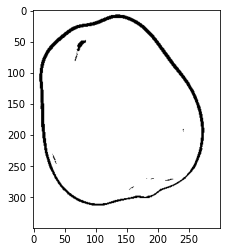

In [65]:
img_blur = cv2.medianBlur(grayscale_imgs_1[0], 25)
threshold = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)

#plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255)
plt.show()